In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
#
INIT_LR = 1e-4  #0.0004
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = 'dataset'
CATEGORIES = ["with mask", "without mask"]
#CATEGORIES[0]

In [6]:
data = []
targets = []

In [7]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	targets.append(category)

In [8]:
(data[6].shape)

(224, 224, 3)

In [9]:
lb = LabelBinarizer()

# transform multi-class labels to binary labels. 
targets = lb.fit_transform(targets)

#returns a numpy array having columns equal to the number of categories in the data.
# 'with mask' and 'without mask'
targets = to_categorical(targets)

In [10]:
data = np.array(data, dtype="float32")
targets = np.array(targets)

In [11]:
print(targets)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
print(data)

[[[[ 0.7647059   0.6         0.18431377]
   [ 0.67058825  0.54509807  0.13725495]
   [ 0.8745098   0.79607844  0.39607847]
   ...
   [ 0.73333335  0.6627451   0.5294118 ]
   [ 0.8980392   0.81960785  0.7411765 ]
   [-0.46666664 -0.5686275  -0.6392157 ]]

  [[ 0.62352943  0.45882356  0.12156868]
   [ 0.7254902   0.5764706   0.24705887]
   [ 0.8666667   0.7176471   0.4039216 ]
   ...
   [ 0.5686275   0.49803925  0.27058828]
   [ 0.8901961   0.8901961   0.6862745 ]
   [-0.5686275  -0.5058824  -0.67058825]]

  [[ 0.6627451   0.52156866  0.20784318]
   [ 0.7254902   0.5529412   0.24705887]
   [ 0.8980392   0.67058825  0.4039216 ]
   ...
   [ 0.827451    0.75686276  0.43529415]
   [ 0.62352943  0.6627451   0.34901965]
   [-0.6862745  -0.5686275  -0.79607844]]

  ...

  [[-0.8901961  -0.8117647  -1.        ]
   [-0.9607843  -0.92941177 -1.        ]
   [-0.58431375 -0.5686275  -0.654902  ]
   ...
   [ 0.94509804  0.58431375  0.6       ]
   [ 0.85882354  0.64705884  0.5137255 ]
   [-0.41176468 

In [13]:
# train_test_split() performs the split and returns four sequences
(trainX, testX, trainY, testY) = train_test_split(data, targets,
	test_size=0.20, stratify=targets, random_state=42)

In [18]:
print( trainX.shape, testX.shape, trainY.shape, testY.shape)

(1100, 224, 224, 3) (276, 224, 224, 3) (1100, 2) (276, 2) 276


In [12]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

/Users/roshitab/opt/anaconda3/envs/CWPProject1/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [14]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)

# 128 refers to the neurons in the hidden layer
headModel = Dense(128, activation="relu")(headModel)

# 0.5 refers to the fraction of the input that is dropped
headModel = Dropout(0.5)(headModel)

# 2 refers to the neurons in the output layer
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
#accuracy computers the accuracy rate across all our predictions

[INFO] compiling model...


In [17]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 98s 3s/step - loss: 0.7153 - accuracy: 0.6283 - val_loss: 0.2656 - val_accuracy: 0.9219
Epoch 2/20
34/34 [==============================] - 94s 3s/step - loss: 0.4371 - accuracy: 0.8015 - val_loss: 0.1654 - val_accuracy: 0.9609
Epoch 3/20
34/34 [==============================] - 92s 3s/step - loss: 0.3288 - accuracy: 0.8605 - val_loss: 0.1208 - val_accuracy: 0.9766
Epoch 4/20
34/34 [==============================] - 95s 3s/step - loss: 0.2690 - accuracy: 0.8933 - val_loss: 0.0925 - val_accuracy: 0.9844
Epoch 5/20
34/34 [==============================] - 94s 3s/step - loss: 0.2152 - accuracy: 0.9213 - val_loss: 0.0831 - val_accuracy: 0.9844
Epoch 6/20
34/34 [==============================] - 96s 3s/step - loss: 0.2003 - accuracy: 0.9298 - val_loss: 0.0688 - val_accuracy: 0.9883
Epoch 7/20
34/34 [==============================] - 96s 3s/step - loss: 0.1717 - accuracy: 0

In [18]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with mask       0.99      1.00      0.99       138
without mask       1.00      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [19]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


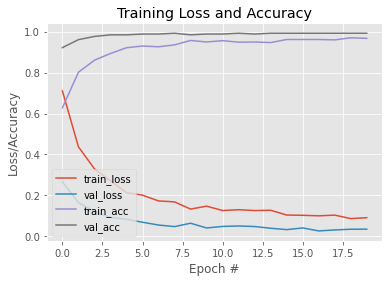

In [20]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")